# Install ptitprince and load libraries

In [1]:
!pip install ptitprince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ptitprince: filename=ptitprince-0.3.1-py3-none-any.whl size=16216 sha256=e3dfb22d38e63fe9a2ec1811aa619073a5ef0b26ce06ff590965839f073b2eb8
  Stored in directory: /root/.cache/pip/wheels/5d/79/49/b89a41fd3d8780ce2c21c7f2debe45f3c6b08d8aef400e3df1
Successfully built ptitprince


In [2]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 37.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Datasets Needed




combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries_global_ns.csv, combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries.csv,
ne_110m_admin_0_countries.zip

# Maps

###urban city

/tmp/ipython-input-3576611828.py:75: RuntimeWarning: NDVI outside [0,1] detected; values will be clipped.
  warnings.warn("NDVI outside [0,1] detected; values will be clipped.", RuntimeWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws

Map saved to -> /content/drive/MyDrive/UrbanVegetation/Figures/FigSI1_uvp_NDVI_map_top1000.png


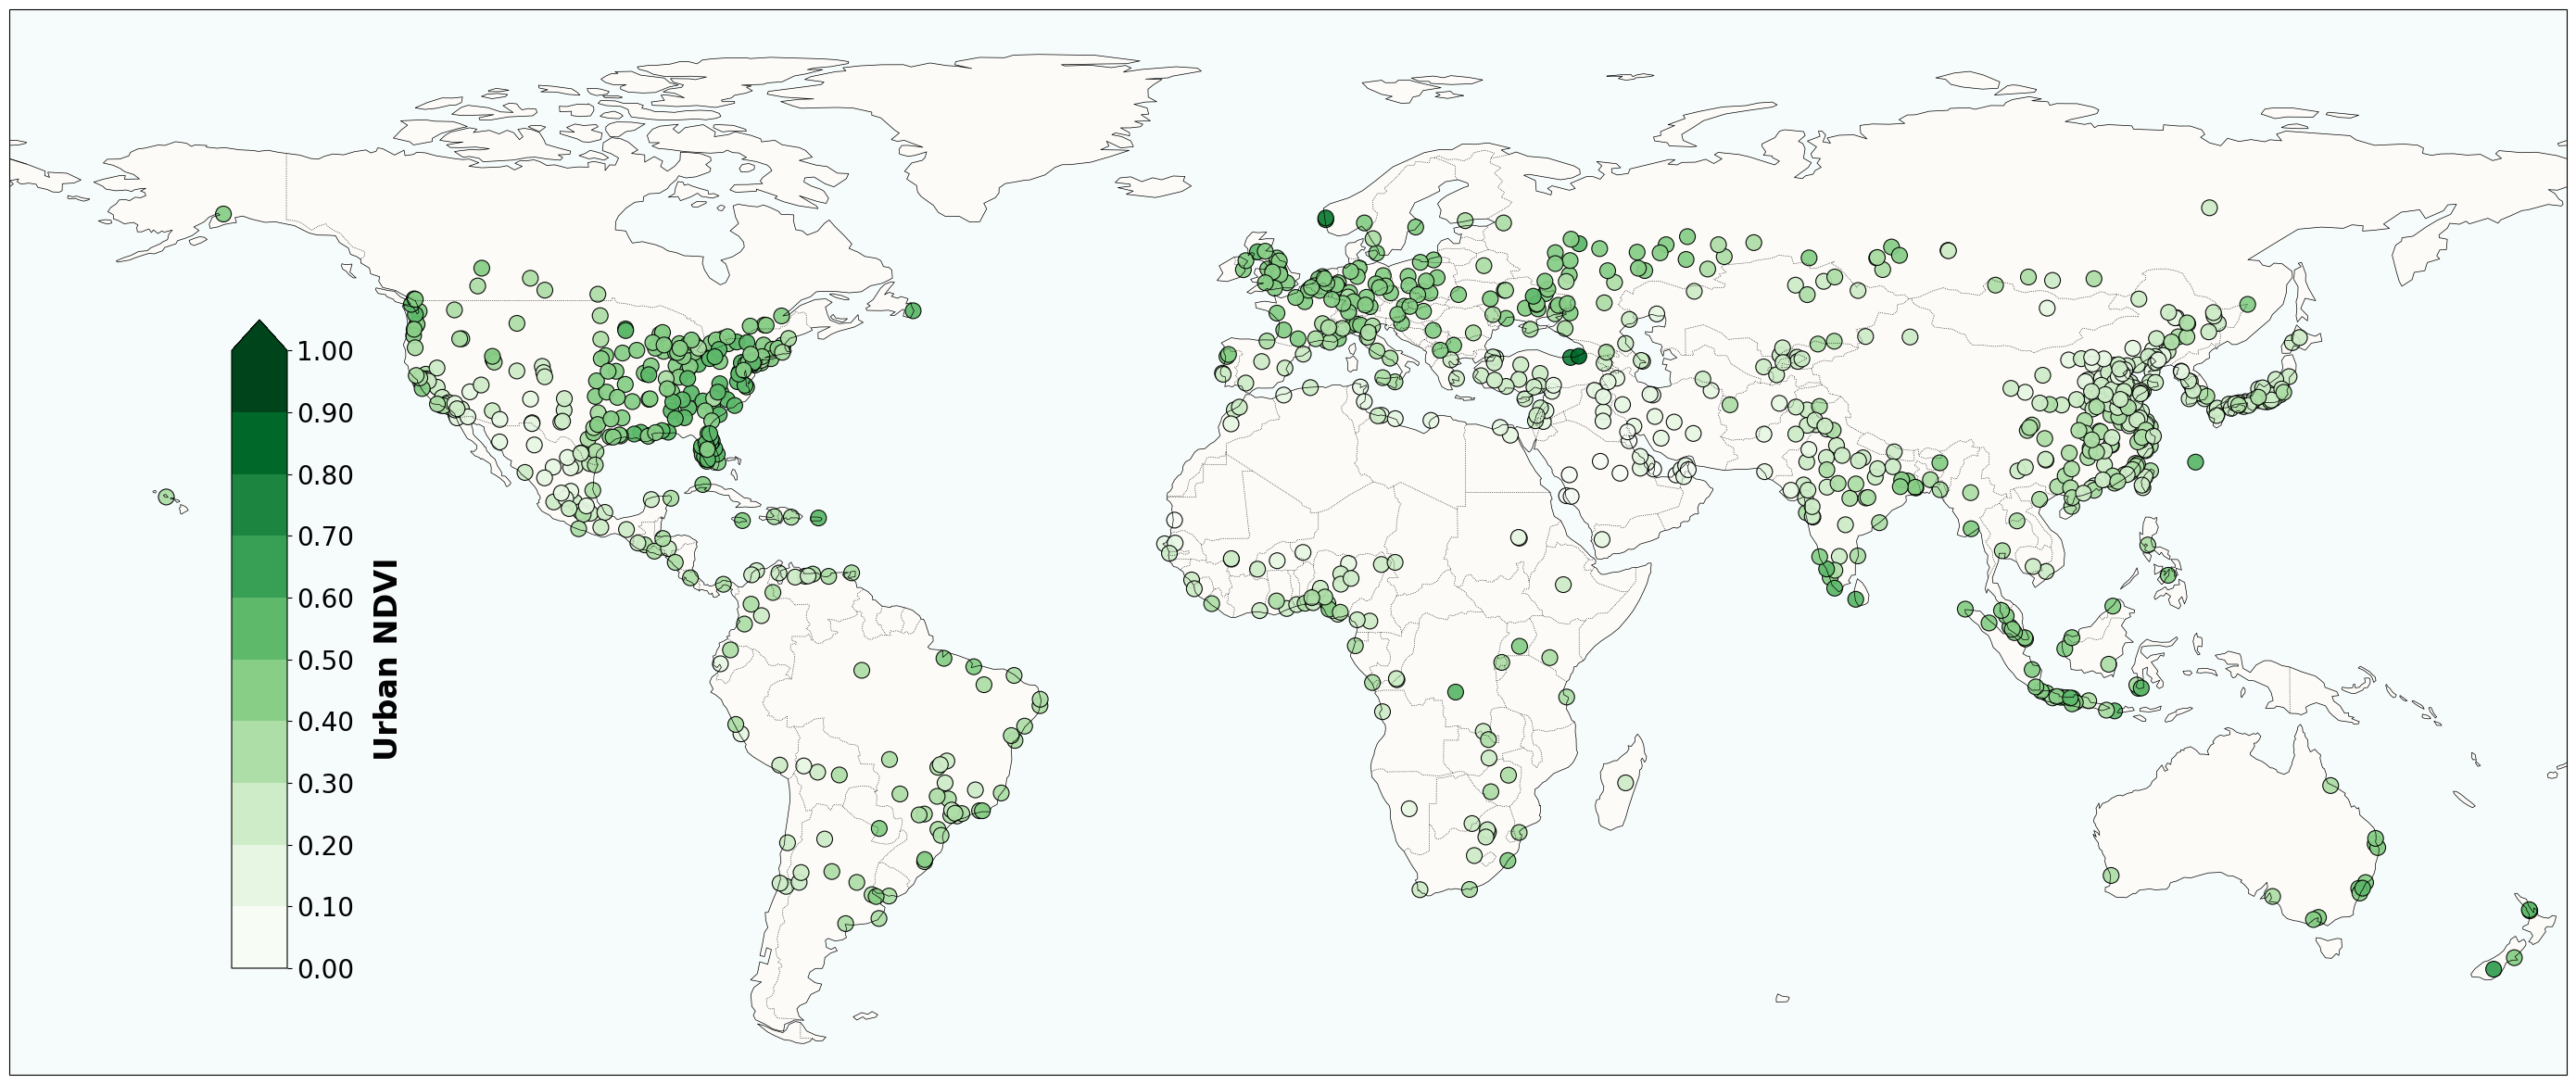

Histogram saved to -> /content/drive/MyDrive/UrbanVegetation/Figures/FigSI1_uvp_NDVI_hist_top1000.png


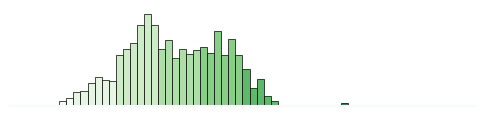


--- NDVI summary (top 1000 by Urban_Area) ---
count   1000.000
mean       0.340
std        0.116
min        0.066
10%        0.194
50%        0.331
90%        0.488
max        0.813
Discrete bounds: 0.00 → 1.00 (10 classes)
Quantile scaling: False  (Q_LOW=0.02, Q_HIGH=0.98)


In [23]:
#!/usr/bin/env python3


# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable


# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
CSV_PATH   = Path('/content/combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries.csv')
OUT_DIR    = Path('/content/drive/MyDrive/UrbanVegetation/Figures/')
OUT_MAP    = OUT_DIR / 'FigSI1_uvp_NDVI_map_top1000.png'
OUT_HIST   = OUT_DIR / 'FigSI1_uvp_NDVI_hist_top1000.png'

NUM_COLOR_BINS = 10   # discrete classes on the map (sequential)
NUM_HIST_BINS  = 60   # histogram detail

SEQUENTIAL_CMAP = plt.cm.Greens

# Range strategy:
USE_QUANTILE_RANGE = False   # if True, use robust [q_low, q_high]; else use [0, 1]
Q_LOW, Q_HIGH = 0.02, 0.98   # quantile bounds when USE_QUANTILE_RANGE=True

# Required columns
REQ = ['meanNDVI_2020_urban', 'Urban_Area', 'lat', 'lon']


# ------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------
def _validate_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure required columns exist & numeric; drop NaNs and invalid coords; clip NDVI to [0,1]."""
    missing = [c for c in REQ if c not in df.columns]
    if missing:
        raise ValueError(f"ERROR: Missing required column(s): {missing!r}")

    # Coerce types
    for c in REQ:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Drop NaNs
    df = df.dropna(subset=REQ)
    if df.empty:
        raise ValueError("No valid rows remain after dropping NaNs in required columns.")

    # Valid lat/lon
    valid_xy = df['lat'].between(-90, 90) & df['lon'].between(-180, 180)
    if not valid_xy.all():
        df = df[valid_xy]
        warnings.warn("Some rows removed due to invalid lat/lon.", RuntimeWarning)
    if df.empty:
        raise ValueError("All rows removed due to invalid lat/lon.")

    # Positive urban area
    df = df[df['Urban_Area'] > 0].copy()
    if df.empty:
        raise ValueError("All rows removed due to non-positive Urban_Area.")

    # NDVI validation & clipping
    ndvi = df['meanNDVI_2020_urban']
    if ((ndvi < 0).any()) or ((ndvi > 1).any()):
        warnings.warn("NDVI outside [0,1] detected; values will be clipped.", RuntimeWarning)
    df['meanNDVI_2020_urban'] = ndvi.clip(lower=0.0, upper=1.0)

    return df


def _compute_bounds(vals: np.ndarray) -> np.ndarray:
    """Compute discrete sequential bounds: either [0,1] or robust quantiles."""
    if USE_QUANTILE_RANGE:
        vmin = float(np.nanquantile(vals, Q_LOW))
        vmax = float(np.nanquantile(vals, Q_HIGH))
        # guardrails
        vmin = max(0.0, min(vmin, 1.0))
        vmax = max(vmin + 1e-6, min(vmax, 1.0))  # ensure strictly increasing
    else:
        vmin, vmax = 0.0, 1.0

    bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
    return bounds


def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    """Creates a minimalist histogram colored by the same discrete scheme."""
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)

    # Clip to map bounds for exact visual consistency
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])
    if series.empty:
        print("No data available in the specified range for the histogram – skipped.")
        return

    fig, ax = plt.subplots(figsize=(6, 1.25))
    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black', linewidth=0.5
    )

    # Color each bar by its bin center
    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2.0)))

    # Minimalist styling
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.5)

    fig.patch.set_alpha(0); ax.patch.set_alpha(0)
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=400, bbox_inches='tight', format='png', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()


# ------------------------------------------------------------------
# MAIN
# ------------------------------------------------------------------
def analyze_and_plot_ndvi(csv_file: Path):
    if not csv_file.is_file():
        raise FileNotFoundError(f"ERROR: Input CSV not found -> {csv_file}")

    # Load
    df = pd.read_csv(csv_file, low_memory=False)

    # Validate & clean
    df = _validate_and_clean(df)

    # Top 1000 by Urban_Area
    df_top = df.nlargest(1000, 'Urban_Area').copy()
    if df_top.empty:
        raise ValueError("No rows available after selecting top 1000 by Urban_Area.")

    # Bounds & normalization
    vals   = df_top['meanNDVI_2020_urban'].to_numpy()
    bounds = _compute_bounds(vals)
    norm   = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)

    # Map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND,    facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN,   facecolor='lightblue', alpha=0.10)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.5, linestyle=':')

    sc = ax.scatter(
        df_top['lon'], df_top['lat'],
        c=df_top['meanNDVI_2020_urban'],
        cmap=SEQUENTIAL_CMAP, norm=norm,
        s=150, alpha=0.95,
        edgecolors='black', linewidths=0.8,
        transform=ccrs.PlateCarree()
    )
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # Colorbar
    cax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm  = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP); sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='max')
    cbar.set_label('Urban NDVI', fontsize=24, labelpad=15, fontweight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f'{b:.2f}' for b in bounds])
    cbar.ax.tick_params(labelsize=20)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_MAP, dpi=400, bbox_inches='tight', format='png', transparent=True)
    print(f"Map saved to -> {OUT_MAP}")
    plt.show()

    # Histogram
    minimalist_hist(
        series=df_top['meanNDVI_2020_urban'],
        bounds_arr=bounds,
        bins=NUM_HIST_BINS,
        cmap_obj=SEQUENTIAL_CMAP,
        path=OUT_HIST
    )

    # Summary (quick QC)
    s = df_top['meanNDVI_2020_urban'].describe(percentiles=[0.1, 0.5, 0.9])
    print("\n--- NDVI summary (top 1000 by Urban_Area) ---")
    print(s.to_string(float_format=lambda x: f"{x:.3f}"))
    print(f"Discrete bounds: {bounds[0]:.2f} → {bounds[-1]:.2f} ({len(bounds)-1} classes)")
    print(f"Quantile scaling: {USE_QUANTILE_RANGE}  (Q_LOW={Q_LOW}, Q_HIGH={Q_HIGH})")


# ------------------------------------------------------------------
# EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    try:
        analyze_and_plot_ndvi(CSV_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(f"A critical error occurred: {e}", file=sys.stderr)
        sys.exit(1)


###urban country

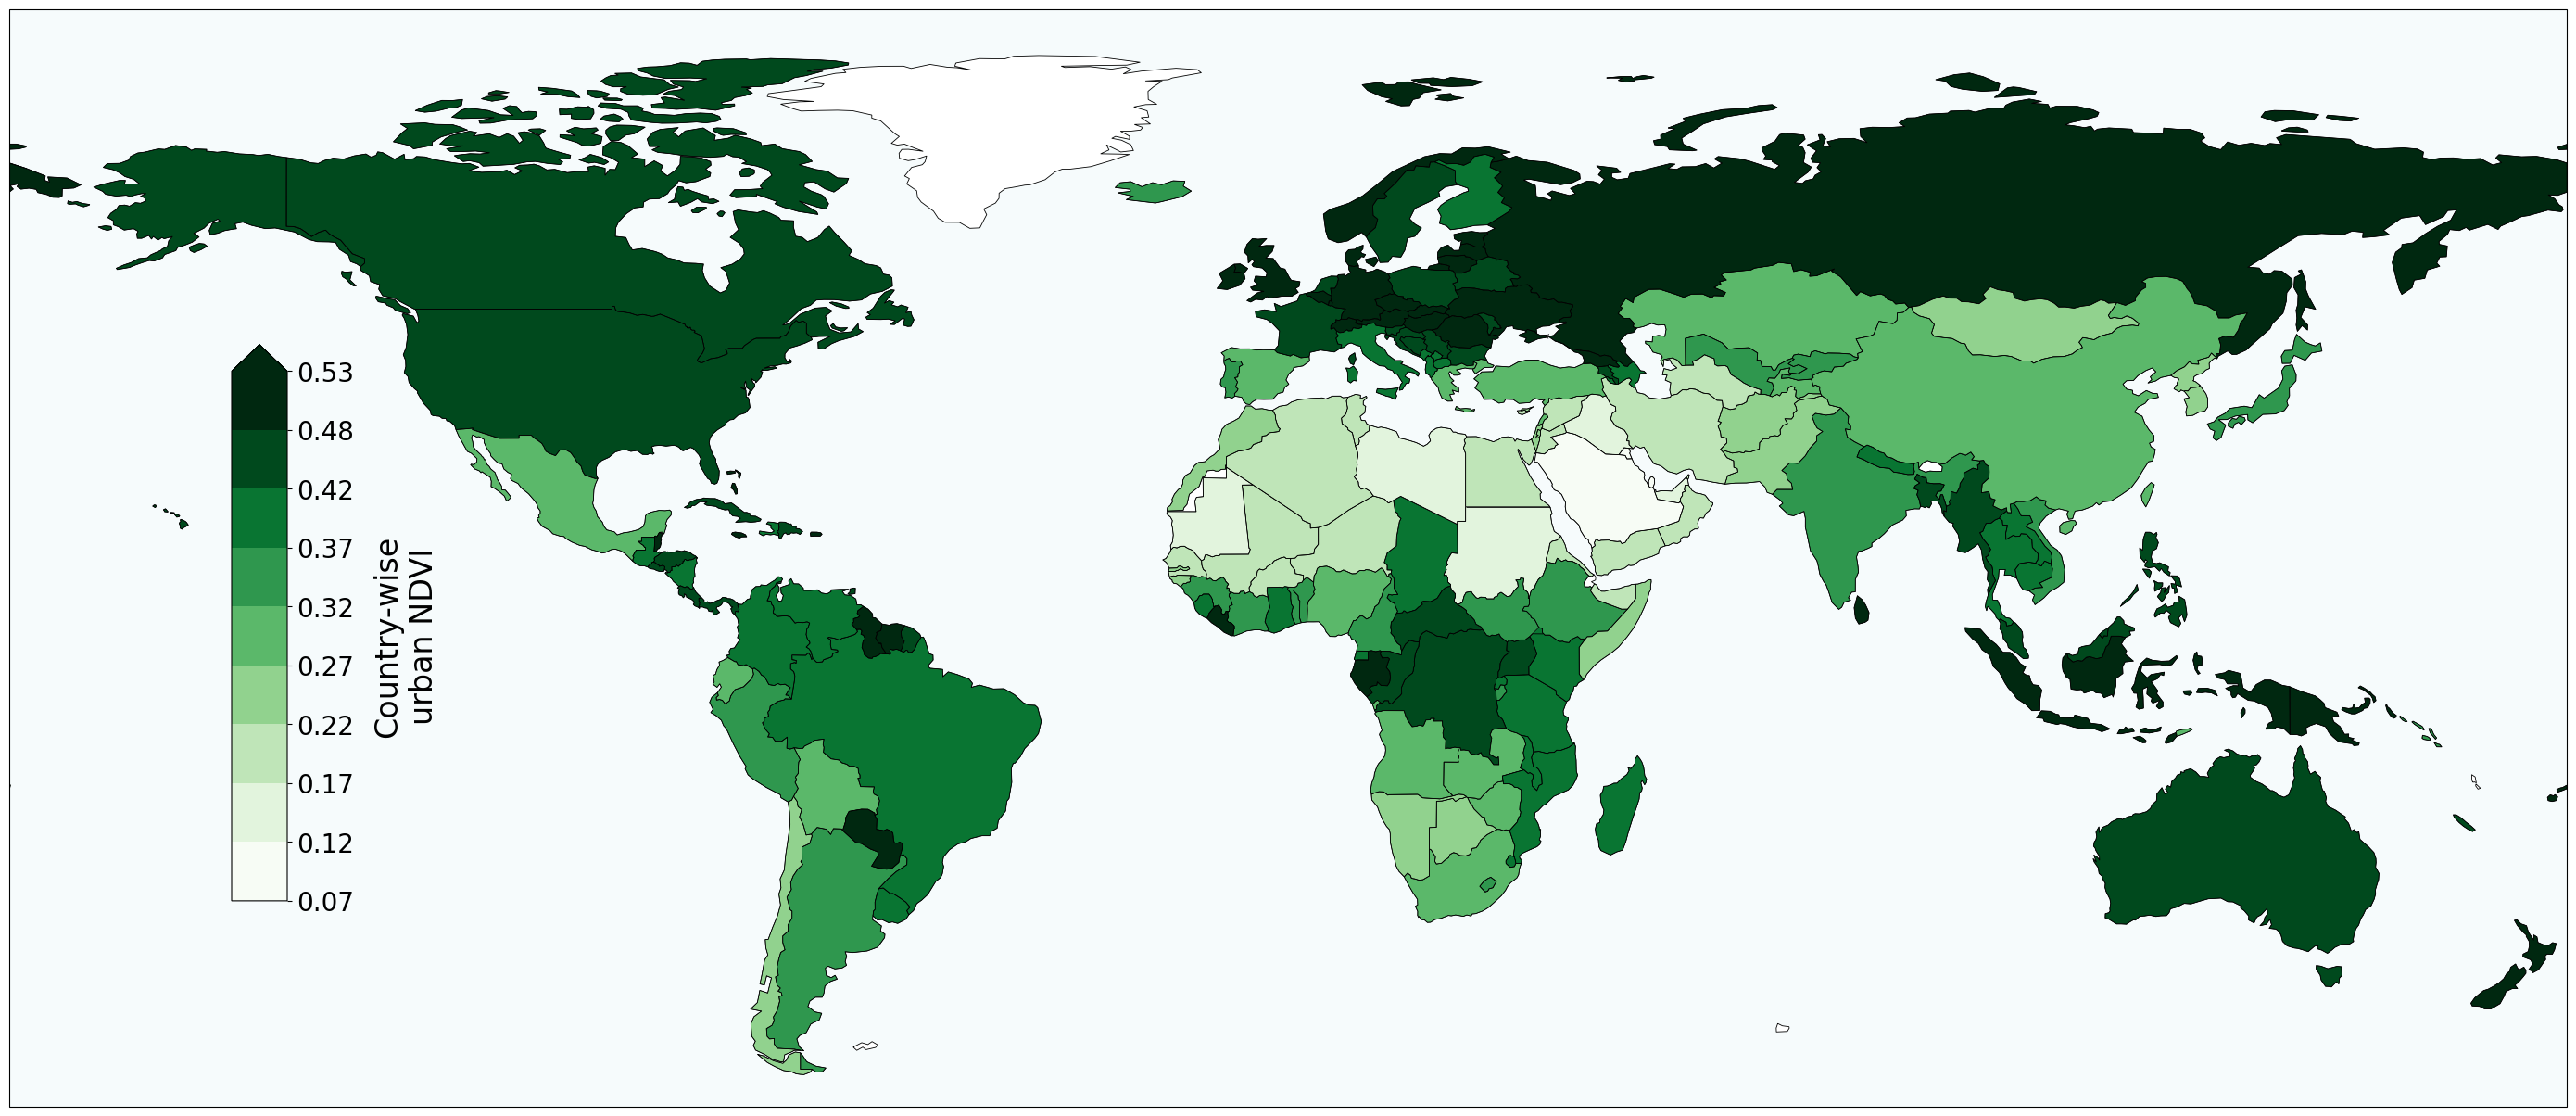

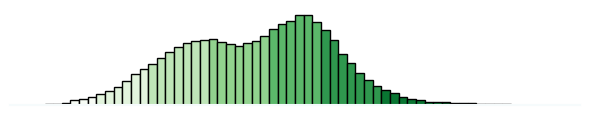

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

def aggregate_mean_tree_height_by_country(data, shapefile_path, save_fig_path):
    """
    Aggregates mean tree height by country and creates a choropleth map
    using a green color ramp with 10 classes.
    """
    # Check required columns
    required_columns = ['meanNDVI_2020_urban', 'NAME_EN']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Required column '{col}' not found in the data.")

    # Convert tree height column to numeric and drop missing values
    data['meanNDVI_2020_urban'] = pd.to_numeric(data['meanNDVI_2020_urban'], errors='coerce')
    data_clean = data.dropna(subset=required_columns)

    try:
        country_tree_height = data_clean.groupby('NAME_EN', as_index=False)['meanNDVI_2020_urban'].mean()
        country_tree_height.rename(columns={'meanNDVI_2020_urban': 'mean_tree_height'}, inplace=True)

        # **Remove countries where mean tree height is exactly 0**
        country_tree_height = country_tree_height[country_tree_height['mean_tree_height'] > 0]

    except Exception as e:
        raise RuntimeError(f"Error during aggregation: {e}")

    try:
        world = gpd.read_file(shapefile_path)
        if 'ADMIN' in world.columns:
            world = world[world['ADMIN'] != 'Antarctica']
        elif 'NAME_EN' in world.columns:
            world = world[world['NAME_EN'] != 'Antarctica']
    except Exception as e:
        raise FileNotFoundError(f"Error reading shapefile '{shapefile_path}': {e}")

    def _standardize_names(s):
        return (s.str.lower()
                .str.replace("&", "and")
                .str.replace("-", " ")
                .str.replace(".", "")
                .str.replace(",", ""))

    try:
        country_tree_height['std_name'] = _standardize_names(country_tree_height['NAME_EN'])
        if 'NAME_EN' in world.columns:
            world['std_name'] = _standardize_names(world['NAME_EN'])
        else:
            world['std_name'] = _standardize_names(world['ADMIN'])
    except Exception as e:
        raise RuntimeError(f"Error standardizing country names: {e}")

    try:
        merged = world.merge(country_tree_height, how='left', on='std_name')
        merged = merged.dropna(subset=['mean_tree_height'])

    except Exception as e:
        raise RuntimeError(f"Error merging geospatial data: {e}")

    if merged.empty:
        raise ValueError("Merged geodataframe is empty after filtering. Check country name matching.")

    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})

        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid_data = merged['mean_tree_height'].dropna()
        if len(valid_data) == 0:
            raise ValueError("No valid mean_tree_height values found for plotting.")

        min_val = max(0, valid_data.min())
        max_val = np.percentile(valid_data, 95)

        # Set the number of classes to 10
        num_bins = 10
        bounds = np.linspace(min_val, max_val, num_bins)

        # Use a green color palette with 10 colors
        cmap = LinearSegmentedColormap.from_list("tree_height_cmap", green_colors, N=256)
        norm = BoundaryNorm(boundaries=bounds, ncolors=256)

        merged.plot(
            column='mean_tree_height',
            ax=ax,
            cmap=cmap,
            norm=norm,
            edgecolor='black',
            linewidth=0.4,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        cbar_ax = fig.add_axes([0.13, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
        cbar.set_label('Country-wise\nurban NDVI', fontsize=24, labelpad=15)
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=20)

        plt.subplots_adjust(left=0.05, right=0.97, top=0.92, bottom=0.05)
        os.makedirs(os.path.dirname(save_fig_path), exist_ok=True)
        plt.savefig(save_fig_path, dpi=400, bbox_inches='tight', format='png')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during plotting: {e}")


def create_tree_height_histogram(data, save_fig_path):
    """
    Creates a standalone histogram of mean tree height values using a green colormap.
    """
    if isinstance(data, pd.DataFrame):
        if 'meanNDVI_2020_urban' not in data.columns:
            raise ValueError("Required column 'meanNDVI_2020_urban' not found in the data.")
        data_series = data['meanNDVI_2020_urban']
    elif isinstance(data, pd.Series):
        data_series = data
    else:
        raise ValueError("Data must be a pandas DataFrame or Series.")

    data_series = pd.to_numeric(data_series, errors='coerce').dropna()

    # **Remove zero values**
    data_series = data_series[data_series > 0]

    if data_series.empty:
        raise ValueError("No valid data available for histogram plotting after removing zero values.")

    min_val = max(0, data_series.min())
    max_val = np.percentile(data_series, 100)

    # Set the number of color bins to 10 for the histogram as well for consistency
    num_color_bins = 10
    bounds = np.linspace(min_val, max_val, num_color_bins)

    cmap = LinearSegmentedColormap.from_list("tree_height_cmap", green_colors, N=256)
    norm = BoundaryNorm(boundaries=bounds, ncolors=256)

    num_hist_bins = 60
    bins = np.linspace(min_val, max_val, num_hist_bins + 1)

    try:
        fig, ax = plt.subplots(figsize=(6, 1.25))
        counts, bin_edges, patches = ax.hist(data_series, bins=bins, edgecolor='black')
        for patch, left_edge, right_edge in zip(patches, bin_edges[:-1], bin_edges[1:]):
            mid_point = (left_edge + right_edge) / 2.0
            if mid_point > max_val:
                mid_point = max_val
            color_index = norm(mid_point)
            patch.set_facecolor(cmap(color_index))

        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.5)

        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        plt.tight_layout()
        directory = os.path.dirname(save_fig_path)
        if directory:
            os.makedirs(directory, exist_ok=True)
        plt.savefig(save_fig_path, dpi=400, bbox_inches='tight', format='png')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during histogram plotting: {e}")


if __name__ == "__main__":
    # Define file paths (update these paths as necessary)
    csv_file_path = '/content/combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries.csv'
    shapefile_path = '/content/ne_110m_admin_0_countries.shp'
    choropleth_save_fig_path = '/content/drive/MyDrive/UrbanVegetation/Figures/FigSI3_uvp_NDVI_by_country_map.png'
    histogram_save_fig_path = '/content/drive/MyDrive/UrbanVegetation/Figures/FigSI3_uvp_NDVI_histogram.png'

    # Define the discrete colormap for the entire visualization with 10 colors
    green_colors = ['#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476',
                    '#41ab5d', '#238b45', '#006d2c', '#00441b', '#002810']


    # Load CSV data with error handling
    try:
        data = pd.read_csv(csv_file_path, low_memory=False)
    except Exception as e:
        raise FileNotFoundError(f"Error reading CSV file '{csv_file_path}': {e}")

    # Generate choropleth map with inset histogram
    try:
        aggregate_mean_tree_height_by_country(data, shapefile_path, choropleth_save_fig_path)
    except Exception as e:
        print(f"An error occurred in choropleth mapping: {e}")

    # Generate a separate histogram plot
    try:
        create_tree_height_histogram(data, histogram_save_fig_path)
    except Exception as e:
        print(f"An error occurred in histogram plotting: {e}")

###urban rural country

Keeping 169 countries with ≥1 city/cities.
Difference map saved to: /content/drive/MyDrive/UrbanVegetation/Figures/FigS1_country_NDVI_difference_map.png


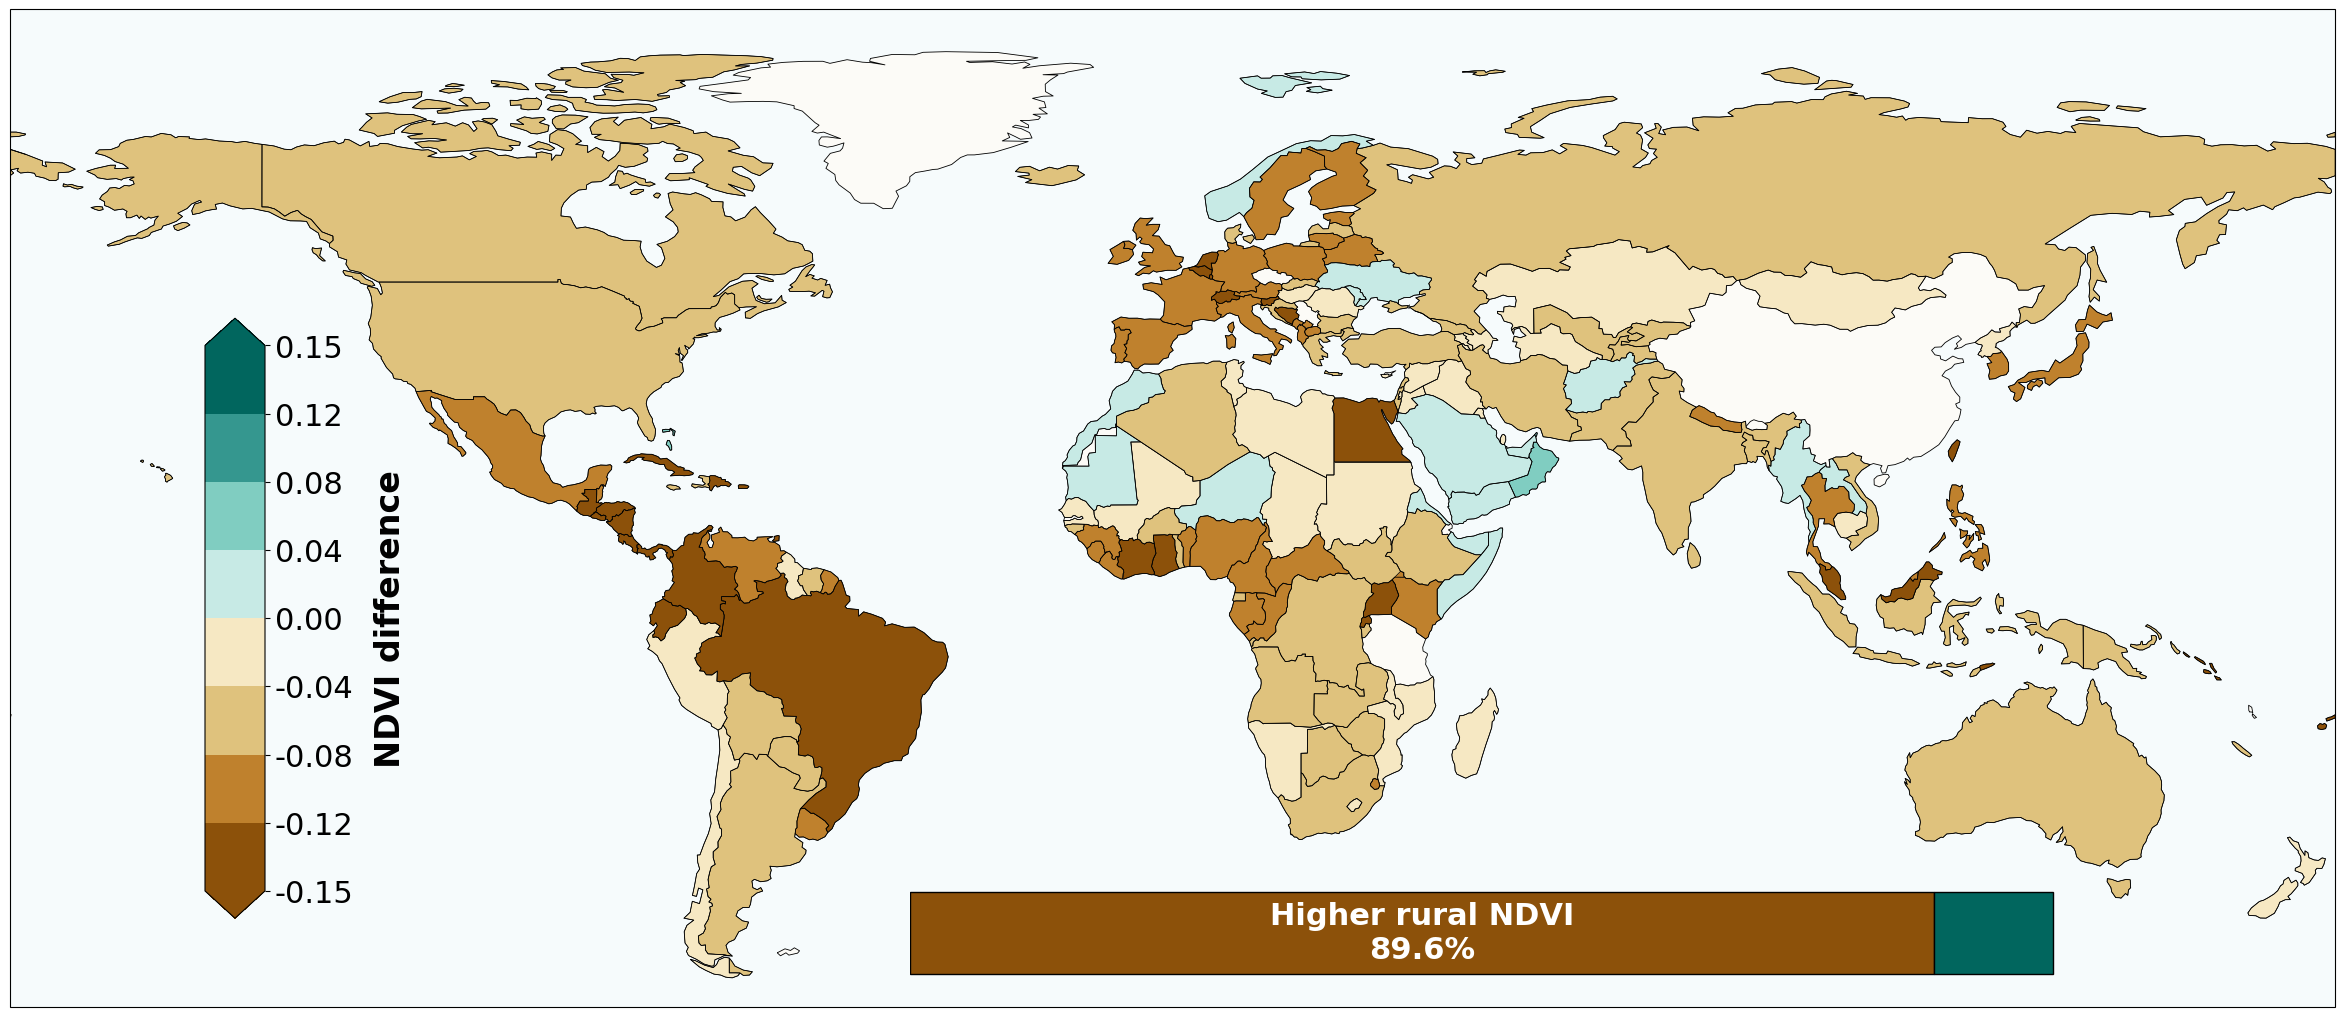

Difference histogram saved to: /content/drive/MyDrive/UrbanVegetation/Figures/FigS1_country_NDVI_difference_histogram.png


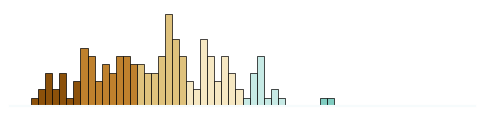

In [ ]:
#!/usr/bin/env python3


# ─────────────────────────────────────────────────────────────────────────────
# 1. IMPORTS & CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable
from pathlib import Path

# ─── User Configuration ───────────────────────────────────────────────────────
CSV_FILE_PATH       = Path("/content/combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries.csv")
SHAPEFILE_PATH      = Path("/content/ne_110m_admin_0_countries.shp")
OUTPUT_DIR          = Path("/content/drive/MyDrive/UrbanVegetation/Figures")

CHOROPLETH_FIG_PATH = OUTPUT_DIR / "FigS1_country_NDVI_difference_map.png"
HISTOGRAM_FIG_PATH  = OUTPUT_DIR / "FigS1_country_NDVI_difference_histogram.png"

# Parameters
MIN_CITIES          = 1      # min cities per country
NUM_COLOR_BINS      = 8      # even number → zero is a class boundary
NUM_HIST_BINS       = 60

# Diverging palette (brown → white → green); white is the conceptual center only.
# We will REMOVE the center color to enforce a hard class break at 0.
DIVERGING_COLORS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
NEG_COLOR = '#8c510a'
POS_COLOR = '#01665e'

# Percent bar (figure coordinates)
PCT_BAR_BOX       = [0.425, 0.26, 0.4, 0.045]  # [left, bottom, width, height]
PCT_BAR_FONTSIZE  = 22
INCLUDE_ZERO_IN_PCT = False  # False: exclude exact zeros from denominator

# ─────────────────────────────────────────────────────────────────────────────
# 2. HELPERS
# ─────────────────────────────────────────────────────────────────────────────
def _standardize_names(s: pd.Series) -> pd.Series:
    """Lower-case & clean names for reliable merging between data and shapefiles."""
    return (s.str.lower()
             .str.replace("&", "and", regex=False)
             .str.replace("-", " ", regex=False)
             .str.replace("[.,]", "", regex=True)
             .str.strip())

def _split_center_palette(cols):
    """Split odd-length diverging palette into negative and positive sides; drop center."""
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLORS must have odd length with a single center color.")
    mid = len(cols) // 2
    neg = cols[:mid]
    pos = cols[mid+1:]
    if len(neg) != len(pos):
        raise ValueError("Negative and positive sides must be symmetric in length.")
    return neg, pos

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    """Symmetric bounds with an exact zero boundary (no center bin)."""
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

def _draw_percent_bar(fig, neg_pct, pos_pct,
                      neg_label="Rural > Urban", pos_label="Urban > Rural",
                      box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
                      left_color=NEG_COLOR, right_color=POS_COLOR):
    """Compact stacked % bar (neg on left, pos on right)."""
    try:
        neg = max(0.0, float(neg_pct))
        pos = max(0.0, float(pos_pct))
    except Exception as e:
        print(f"Warning: invalid percentages for percent bar: {e}")
        return
    if (neg + pos) <= 0:
        return

    axb = fig.add_axes(list(box))
    axb.set_axis_off()

    # Left: negative; Right: positive
    axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.4)
    axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.4, left=neg)

    # Labels (avoid clutter for very small slices)
    if neg > 2:
        axb.text(neg / 2, 0, f"Higher rural NDVI\n{neg:.1f}%", ha='center', va='center',
                 fontsize=fontsize, color='white', weight='bold')
    if pos > 2:
        axb.text(neg + pos / 2, 0, f"", ha='center', va='center',
                 fontsize=fontsize, color='white', weight='bold')

    for s in axb.spines.values():
        s.set_visible(False)
    axb.set_xticks([]); axb.set_yticks([])

# ─────────────────────────────────────────────────────────────────────────────
# 3. DATA PROCESSING
# ─────────────────────────────────────────────────────────────────────────────
def process_data(csv_path: Path, min_cities: int) -> pd.DataFrame:
    """Loads, cleans, and processes NDVI data to find the urban-rural difference."""
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV file not found at: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    required_cols = ["meanNDVI_2020_urban", "meanNDVI_2020_rural", "NAME_EN"]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Required columns not found in the CSV: {missing_cols}")

    for col in ["meanNDVI_2020_urban", "meanNDVI_2020_rural"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=required_cols, inplace=True)

    df['NDVI_diff'] = df['meanNDVI_2020_urban'] - df['meanNDVI_2020_rural']

    # Filter countries by min city count
    vc = df['NAME_EN'].value_counts()
    valid_countries = vc[vc >= min_cities].index
    print(f"Keeping {len(valid_countries)} countries with ≥{min_cities} city/cities.")

    country_diff = (df[df['NAME_EN'].isin(valid_countries)]
                      .groupby("NAME_EN", as_index=False)['NDVI_diff']
                      .mean()
                      .rename(columns={"NDVI_diff": "mean_NDVI_diff"}))
    return country_diff

# ─────────────────────────────────────────────────────────────────────────────
# 4. VISUALIZATION
# ─────────────────────────────────────────────────────────────────────────────
def create_difference_choropleth_with_bar(data: pd.DataFrame,
                                          shapefile_path: Path,
                                          save_fig_path: Path) -> None:
    """Choropleth with exact zero class break + stacked percent bar."""
    if not shapefile_path.is_file():
        raise FileNotFoundError(f"Shapefile not found at: {shapefile_path}")

    world = gpd.read_file(shapefile_path)
    world = world[~world.get("ADMIN", world.get("NAME_EN")).eq("Antarctica")]

    data["std_name"]  = _standardize_names(data["NAME_EN"])
    world["std_name"] = _standardize_names(world.get("ADMIN", world.get("NAME_EN")))
    merged = world.merge(data, how="left", on="std_name")
    merged = merged.dropna(subset=["mean_NDVI_diff"])
    if merged.empty:
        raise ValueError("Merged GeoDataFrame is empty. Check country name matching.")

    values = merged["mean_NDVI_diff"].to_numpy()
    # Robust symmetric span (95th percentile of |diff|)
    abs_limit = np.percentile(np.abs(values), 95)
    abs_limit = max(abs_limit, 1e-4)  # NDVI diffs can be small; avoid zero range

    # Build a zero-split discrete scheme (no center color)
    neg_cols, pos_cols = _split_center_palette(DIVERGING_COLORS)
    if NUM_COLOR_BINS % 2 != 0:
        raise ValueError("NUM_COLOR_BINS must be even to keep 0 as a class boundary.")

    # Use the same number of classes on each side as the palette halves
    n_side = NUM_COLOR_BINS // 2
    # If your palette side length != n_side, resample by slicing
    neg_use = neg_cols[-n_side:] if len(neg_cols) >= n_side else neg_cols
    pos_use = pos_cols[:n_side]  if len(pos_cols) >= n_side else pos_cols
    colors = neg_use + pos_use

    bounds = _build_zero_split_bounds(abs_limit, len(neg_use), len(pos_use))
    cmap   = ListedColormap(colors)
    norm   = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

    # Map plot
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND,     facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN,    facecolor="lightblue", alpha=0.10)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.6)
    ax.set_extent([-180, 180, -60, 90])

    merged.plot(
        column="mean_NDVI_diff",
        ax=ax, cmap=cmap, norm=norm,
        edgecolor="black", linewidth=0.4,
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    # Colorbar
    cax = fig.add_axes([0.19, 0.29, 0.02, 0.30])
    sm  = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", extend="both")
    cbar.set_label("NDVI difference", fontsize=24, labelpad=15, weight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
    cbar.ax.tick_params(labelsize=22)

    # ===== Compact stacked % bar =====
    valid = merged["mean_NDVI_diff"].dropna()
    if INCLUDE_ZERO_IN_PCT:
        base = float(valid.size)
        neg_pct = 100.0 * (valid < 0).sum() / base if base > 0 else 0.0
        pos_pct = 100.0 * (valid > 0).sum() / base if base > 0 else 0.0
    else:
        nz = valid[valid != 0]
        base = float(nz.size)
        neg_pct = 100.0 * (nz < 0).sum() / base if base > 0 else 0.0
        pos_pct = 100.0 * (nz > 0).sum() / base if base > 0 else 0.0

    _draw_percent_bar(
        fig,
        neg_pct=neg_pct, pos_pct=pos_pct,
        neg_label="Rural > Urban", pos_label="Urban > Rural",
        box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
        left_color=NEG_COLOR, right_color=POS_COLOR
    )

    os.makedirs(os.path.dirname(save_fig_path), exist_ok=True)
    plt.savefig(save_fig_path, dpi=400, bbox_inches="tight", format="png", transparent=True)
    print(f"Difference map saved to: {save_fig_path.resolve()}")
    plt.show()

def create_minimalist_histogram(series: pd.Series, bounds_arr: np.ndarray, cmap_obj, path: Path) -> None:
    """Minimalist histogram (kept from your original; uses continuous mapping of value→color)."""
    series_clipped = series[(series >= bounds_arr[0]) & (series <= bounds_arr[-1])]
    if series_clipped.empty:
        print("No data available for the histogram in the specified range.")
        return

    norm_hist = plt.Normalize(vmin=bounds_arr[0], vmax=bounds_arr[-1])
    fig, ax = plt.subplots(figsize=(6, 1.25))
    bins = np.linspace(bounds_arr[0], bounds_arr[-1], NUM_HIST_BINS + 1)
    _, _, patches = ax.hist(series_clipped, bins=bins, edgecolor="black", linewidth=0.5)

    for patch, low_edge, high_edge in zip(patches, bins[:-1], bins[1:]):
        mid_val = (low_edge + high_edge) / 2
        patch.set_facecolor(cmap_obj(norm_hist(mid_val)))

    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("#f6fbfc")
    ax.spines["bottom"].set_linewidth(1.5)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=400, bbox_inches="tight", format="png", transparent=True)
    print(f"Difference histogram saved to: {path.resolve()}")
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 5. MAIN
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    try:
        # 1) Process
        country_data = process_data(CSV_FILE_PATH, MIN_CITIES)

        # 2) Prepare merged GDF once for histogram scale
        world_gdf = gpd.read_file(SHAPEFILE_PATH)
        world_gdf = world_gdf[~world_gdf.get("ADMIN", world_gdf.get("NAME_EN")).eq("Antarctica")]
        country_data["std_name"]  = _standardize_names(country_data["NAME_EN"])
        world_gdf["std_name"]     = _standardize_names(world_gdf.get("ADMIN", world_gdf.get("NAME_EN")))
        merged_gdf = world_gdf.merge(country_data, how="left", on="std_name")
        merged_gdf = merged_gdf.dropna(subset=["mean_NDVI_diff"])

        # Robust symmetric bounds for the histogram to match the map span
        vals = merged_gdf["mean_NDVI_diff"].to_numpy()
        abs_limit = np.percentile(np.abs(vals), 95)
        abs_limit = max(abs_limit, 1e-4)
        # Build zero-split class bounds used by the map (coarse), but the histogram
        # below still uses a continuous colormap based on these end points:
        # (You can swap to a class-colored histogram if desired.)
        neg_cols, pos_cols = _split_center_palette(DIVERGING_COLORS)
        n_side = NUM_COLOR_BINS // 2
        neg_use = neg_cols[-n_side:] if len(neg_cols) >= n_side else neg_cols
        pos_use = pos_cols[:n_side]  if len(pos_cols) >= n_side else pos_cols
        plot_bounds = _build_zero_split_bounds(abs_limit, len(neg_use), len(pos_use))
        # Continuous version using all palette colors for the histogram coloring
        cmap_cont = ListedColormap(neg_cols + pos_cols)

        # 3) Choropleth + % bar
        create_difference_choropleth_with_bar(country_data, SHAPEFILE_PATH, CHOROPLETH_FIG_PATH)

        # 4) Histogram (uses continuous color mapping between min/max of map bounds)
        create_minimalist_histogram(
            series=merged_gdf["mean_NDVI_diff"],
            bounds_arr=np.array([plot_bounds[0], plot_bounds[-1]]),
            cmap_obj=cmap_cont,
            path=HISTOGRAM_FIG_PATH
        )

    except (FileNotFoundError, ValueError, RuntimeError) as e:
        print(f"An error occurred: {e}")


###urban - rural city

Map saved to /content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig8_NDVI_map.pdf


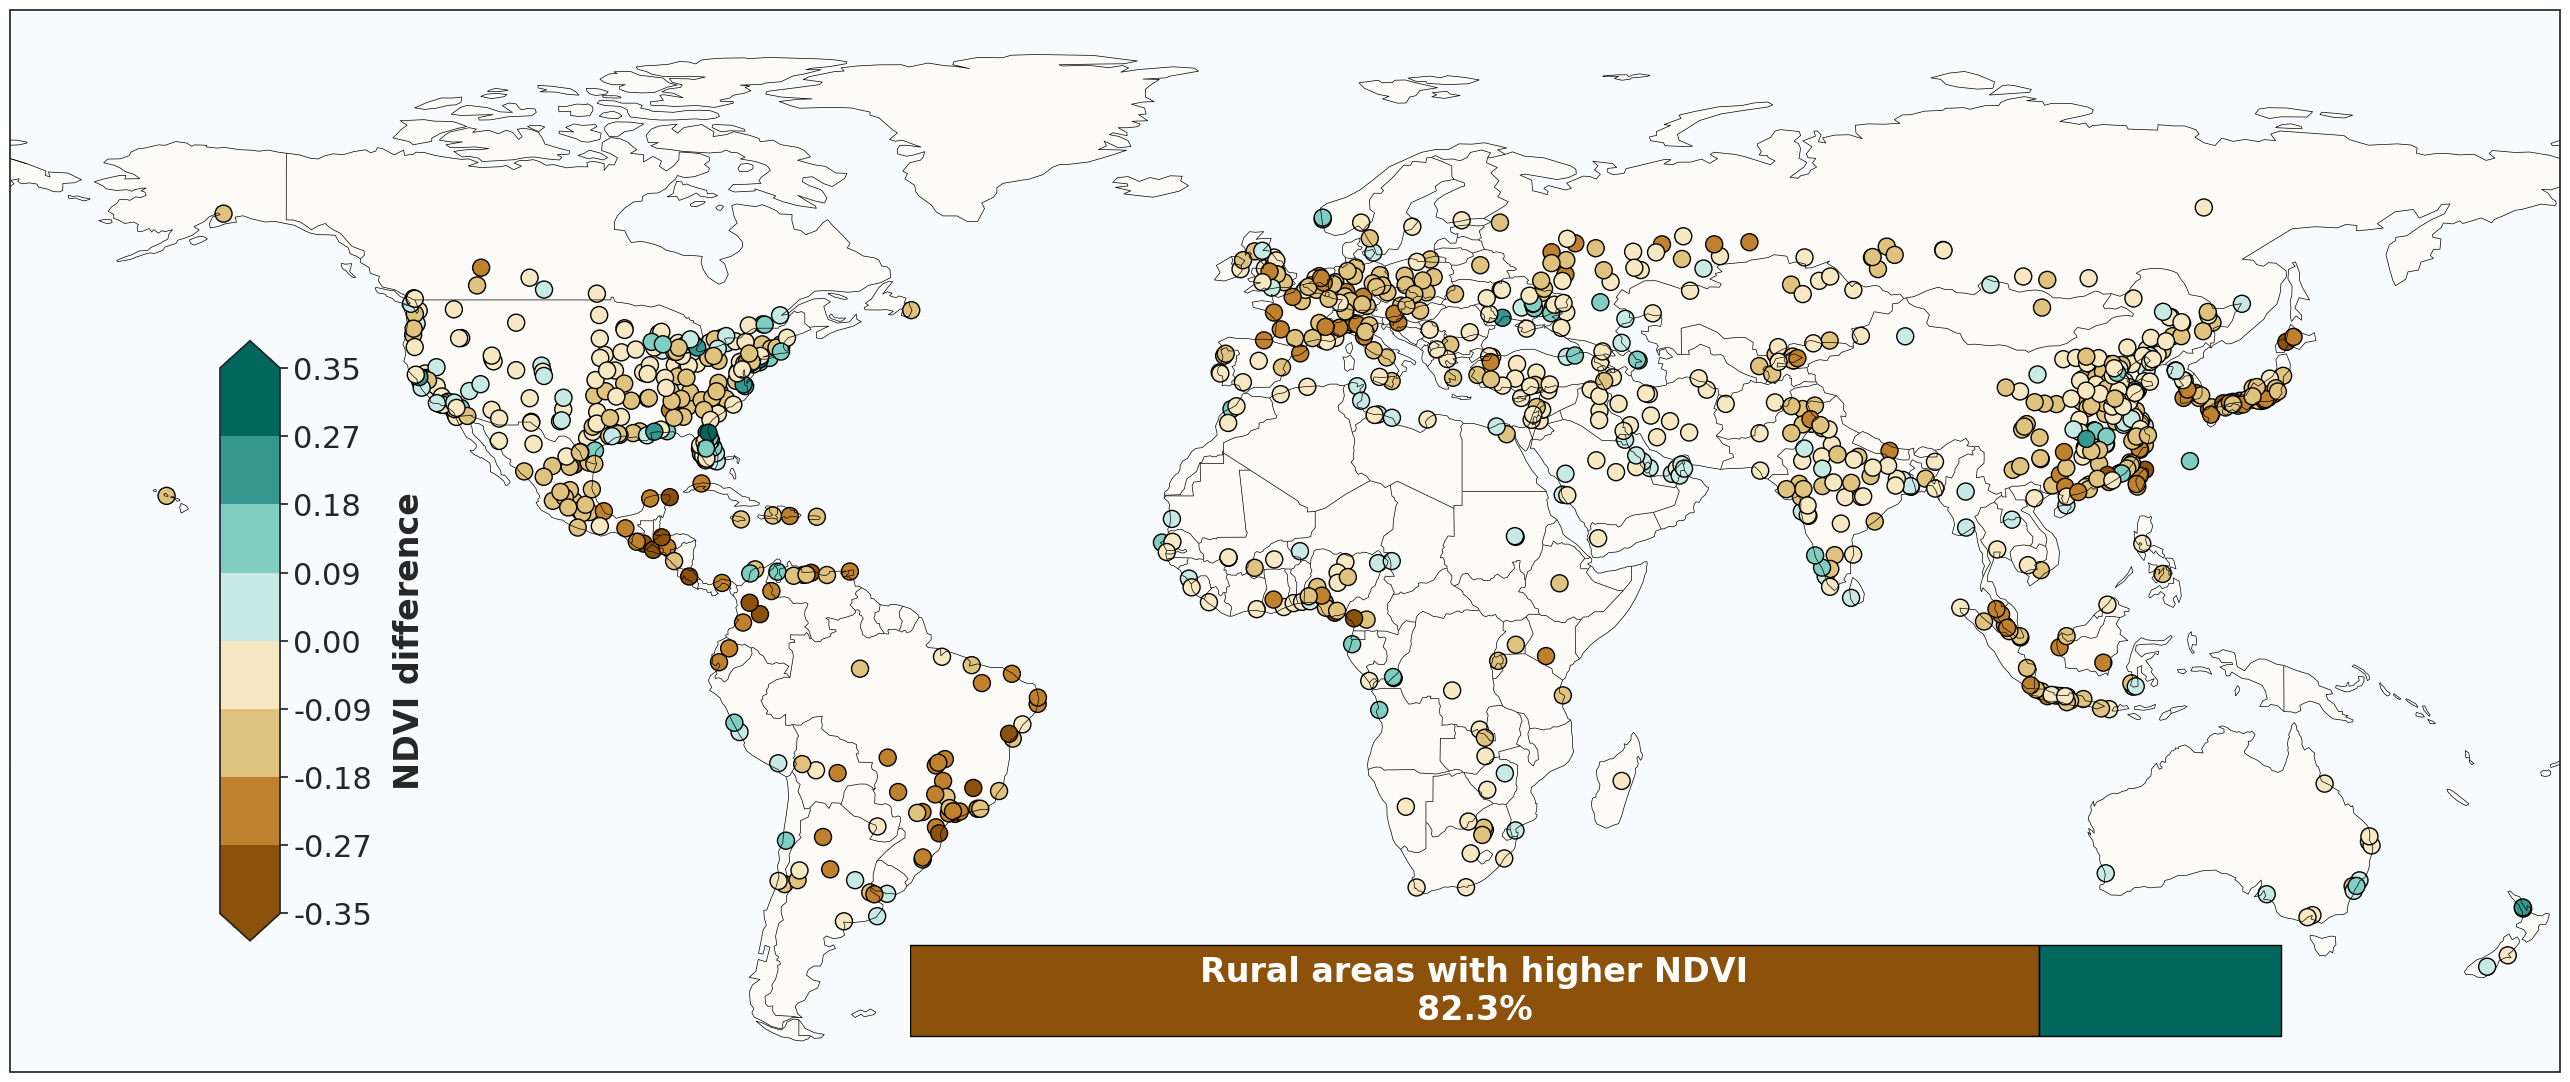

Histogram saved to /content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig8_NDVI_hist.pdf


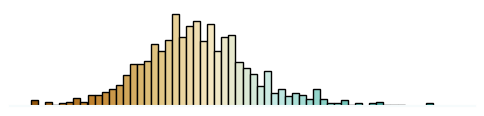

--- NDVI difference summary (top 1000 by Urban_Area) ---
Cities plotted: 1000
Urban higher NDVI (diff > 0): 177 (17.7%)
Rural higher NDVI (diff < 0): 823 (82.3%)
Equal NDVI (diff == 0): 0 (0.0%)
Color scale bounds: [-0.35, 0.35] with 0 as class break


In [ ]:
#!/usr/bin/env python3


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

# ---- Config ----
ABS_MAX_CAP = 0.5  # cap for NDVI difference color scaling (±0.5 typical for NDVI Δ)
N_COLORS = 8       # even number => 0 lies on a bin boundary (class break), not a color
HIST_BINS = 60
OUT_DIR = '/content/drive/MyDrive/UrbanVegetation/FiguresV3'
MAP_NAME = 'EDFig8_NDVI_map.pdf'
HIST_NAME = 'EDFig8_NDVI_hist.pdf'

# Diverging palette (brown → teal), even number of colors (no center color)
PALETTE = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',  # brown side
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'   # teal side
]

REQUIRED_COLUMNS = ['meanNDVI_2020_urban', 'meanNDVI_2020_rural', 'lat', 'lon', 'Urban_Area']


def _validate_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure required columns exist & numeric; drop NaNs and out-of-range coords."""
    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f"Required columns missing: {missing}")

    # Coerce to numeric
    for c in REQUIRED_COLUMNS:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Drop NaNs
    df = df.dropna(subset=REQUIRED_COLUMNS)
    if df.empty:
        raise ValueError("No valid rows remain after dropping NaNs in required columns.")

    # Drop invalid lat/lon
    valid_coords = (df['lat'].between(-90, 90)) & (df['lon'].between(-180, 180))
    df = df[valid_coords]
    if df.empty:
        raise ValueError("All rows removed due to invalid lat/lon ranges.")

    return df


def _compute_bounds(series: pd.Series, n_colors: int, cap: float) -> np.ndarray:
    """
    Compute symmetric bounds around 0 with an even number of bins.
    Ensures 0 is a class break, not a color.
    """
    # NDVI difference realistically in [-0.5, 0.5]; still derive from data then cap
    s = series.dropna().clip(lower=-1.0, upper=1.0)
    if s.empty:
        # fall back to ±cap if series is empty after clipping
        abs_max = cap
    else:
        abs_max = min(cap, max(abs(s.min()), abs(s.max())))
        # guard against degenerate case
        if abs_max <= 0:
            abs_max = cap

    bounds = np.linspace(-abs_max, abs_max, n_colors + 1)
    # Sanity: with even n_colors, mid bound must be ~0
    mid = bounds.size // 2
    if not np.isclose(bounds[mid], 0.0, atol=1e-8):
        # force exact zero at center boundary
        bounds[mid] = 0.0
    return bounds


def create_frequency_histogram(series, lo, hi, bins, cmap_cont, out_dir, out_name):
    """Minimalist frequency histogram with continuous palette."""
    vals = series[(series >= lo) & (series <= hi)].dropna()
    if vals.empty:
        print("Histogram: no data within specified bounds.")
        return

    edges = np.linspace(lo, hi, bins + 1)
    fig, ax = plt.subplots(figsize=(6, 1.25))
    try:
        counts, edges, patches = ax.hist(vals, bins=edges, edgecolor='black')
    except Exception as e:
        print(f"Error generating histogram: {e}")
        plt.close(fig)
        return

    norm = plt.Normalize(vmin=lo, vmax=hi)
    for patch, left, right in zip(patches, edges[:-1], edges[1:]):
        patch.set_facecolor(cmap_cont(norm((left + right) / 2.0)))

    # Minimalist styling
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.5)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, out_name)
    try:
        plt.savefig(out_path, dpi=400, bbox_inches='tight', transparent=True)
        print(f"Histogram saved to {out_path}")
    except Exception as e:
        print(f"Error saving histogram: {e}")
    finally:
        plt.show()
        plt.close(fig)


def analyze_ndvi_difference(file_path: str):
    """
    Loads data, computes NDVI_diff = meanNDVI_2020_urban − meanNDVI_2020_rural,
    selects top 1000 by Urban_Area, plots world scatter + stacked bar, and writes a histogram.
    """
    # 1) Load
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file does not exist: {file_path}")

    # Prefer CSV for this dataset, but allow vector files too.
    try:
        if file_path.lower().endswith(('.csv', '.tsv')):
            df = pd.read_csv(file_path)
        else:
            # Attempt to read with geopandas (shp/gpkg/geojson, etc.)
            gdf = gpd.read_file(file_path)
            df = pd.DataFrame(gdf)
    except Exception as e:
        raise FileNotFoundError(f"Error reading file '{file_path}': {e}")

    # 2) Validate & clean
    df = _validate_and_clean(df)

    # 3) Compute NDVI difference and clamp to reasonable limits
    df['NDVI_diff'] = (df['meanNDVI_2020_urban'] - df['meanNDVI_2020_rural']).clip(-1.0, 1.0)

    # 4) Top 1000 by Urban_Area (after cleaning)
    df = df.nlargest(1000, 'Urban_Area').copy()
    if df.empty:
        raise ValueError("No rows available after selecting top 1000 by Urban_Area.")

    # 5) Colormap/bounds with 0 as class break
    bounds = _compute_bounds(df['NDVI_diff'], N_COLORS, ABS_MAX_CAP)
    cmap_disc = ListedColormap(PALETTE)
    norm_disc = BoundaryNorm(bounds, ncolors=len(PALETTE), clip=True)

    # 6) Map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, lw=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.08)
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')

    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df['NDVI_diff'],
        cmap=cmap_disc, norm=norm_disc,
        s=150, edgecolors='black', linewidths=1,
        transform=ccrs.PlateCarree()
    )

    # Colorbar (ticks exactly at class boundaries)
    cax = fig.add_axes([0.17, 0.30, 0.02, 0.30])
    cbar = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
    cbar.set_label('NDVI difference', fontsize=24, labelpad=15, weight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
    cbar.ax.tick_params(labelsize=22)

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # 7) Stacked bar (Rural-higher on left; Urban-higher on right)
    pos = int((df['NDVI_diff'] > 0).sum())
    neg = int((df['NDVI_diff'] < 0).sum())
    zeros = int((df['NDVI_diff'] == 0).sum())
    total = len(df)

    # Percentages over all selected cities (including zeros so the bar sums ≤ 100 if zeros exist)
    p_pos = 100.0 * pos / total if total else 0.0
    p_neg = 100.0 * neg / total if total else 0.0
    leftover = max(0.0, 100.0 - (p_pos + p_neg))  # share of exact zeros

    bar_ax = fig.add_axes([0.40, 0.25, 0.48, 0.05])
    bar_ax.set_axis_off()

    # Left: Rural higher (negative diffs)
    bar_ax.barh([''], [p_neg], color=PALETTE[0], edgecolor='black', height=0.4, label='Rural higher')

    # Middle (if any): exact 0 (neutral) as a light grey sliver
    if leftover > 0:
        bar_ax.barh([''], [leftover], left=p_neg, color='#e6e6e6', edgecolor='black', height=0.4, label='Equal')

    # Right: Urban higher (positive diffs)
    left_offset = p_neg + leftover
    bar_ax.barh([''], [p_pos], left=left_offset, color=PALETTE[-1], edgecolor='black', height=0.4, label='Urban higher')

    # Text labels
    if p_neg > 0:
        bar_ax.text(p_neg / 2, 0, f"Rural areas with higher NDVI\n{p_neg:.1f}%", ha='center', va='center',
                    fontsize=24, color='white', weight='bold')
    if p_pos > 0:
        bar_ax.text(left_offset + p_pos / 2, 0, f"", ha='center', va='center',
                    fontsize=24, color='white', weight='bold')

    plt.subplots_adjust(left=0.10, right=0.95, top=0.95, bottom=0.05)

    # 8) Save map
    os.makedirs(OUT_DIR, exist_ok=True)
    map_path = os.path.join(OUT_DIR, MAP_NAME)
    try:
        plt.savefig(map_path, dpi=400, bbox_inches='tight', transparent=True)
        print(f"Map saved to {map_path}")
    except Exception as e:
        print(f"Error saving scatter map: {e}")
    finally:
        plt.show()
        plt.close(fig)

    # 9) Histogram with continuous palette over same capped bounds
    cmap_cont = LinearSegmentedColormap.from_list("ndvi_cont", PALETTE, N=256)
    create_frequency_histogram(
        series=df['NDVI_diff'],
        lo=bounds[0],
        hi=bounds[-1],
        bins=HIST_BINS,
        cmap_cont=cmap_cont,
        out_dir=OUT_DIR,
        out_name=HIST_NAME
    )

    # 10) Print summary
    print("--- NDVI difference summary (top 1000 by Urban_Area) ---")
    print(f"Cities plotted: {total}")
    print(f"Urban higher NDVI (diff > 0): {pos} ({p_pos:.1f}%)")
    print(f"Rural higher NDVI (diff < 0): {neg} ({p_neg:.1f}%)")
    print(f"Equal NDVI (diff == 0): {zeros} ({leftover:.1f}%)")
    print(f"Color scale bounds: [{bounds[0]:.2f}, {bounds[-1]:.2f}] with 0 as class break")


if __name__ == "__main__":
    # Example path; update as needed
    input_file = '/content/combinedFeatures_NDVIBiomeKoppen_withLatLon.csv'
    try:
        analyze_ndvi_difference(input_file)
    except Exception as e:
        print(f"Analysis failed: {e}")
        sys.exit(1)


#GNGS

Valid rows after cleaning: 80,341 of 83,102

[Global North] Area-weighted stats for ΔNDVI (Weights: Urban_Area + Buffer_area):
  n_raw                : 30621
  n_eff (Kish)         : 464.1
  μ_w (weighted mean)  : -0.0653
  SE_w (weighted)      : 0.0045
  U > R                : 4600 / 30621 (15.0%)

[Global South] Area-weighted stats for ΔNDVI (Weights: Urban_Area + Buffer_area):
  n_raw                : 49720
  n_eff (Kish)         : 1247.1
  μ_w (weighted mean)  : -0.0777
  SE_w (weighted)      : 0.0025
  U > R                : 10597 / 49720 (21.3%)

─ Tests on unweighted ΔNDVI distributions ─
Mann–Whitney U p-value : 1.5792e-261
Kolmogorov–Smirnov p   : 1.7168e-278
Cohen’s d (effect size): -0.180


/tmp/ipython-input-2370686476.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Figure saved → /content/drive/MyDrive/UrbanVegetation/FiguresV3/NDVI_GNGS.pdf


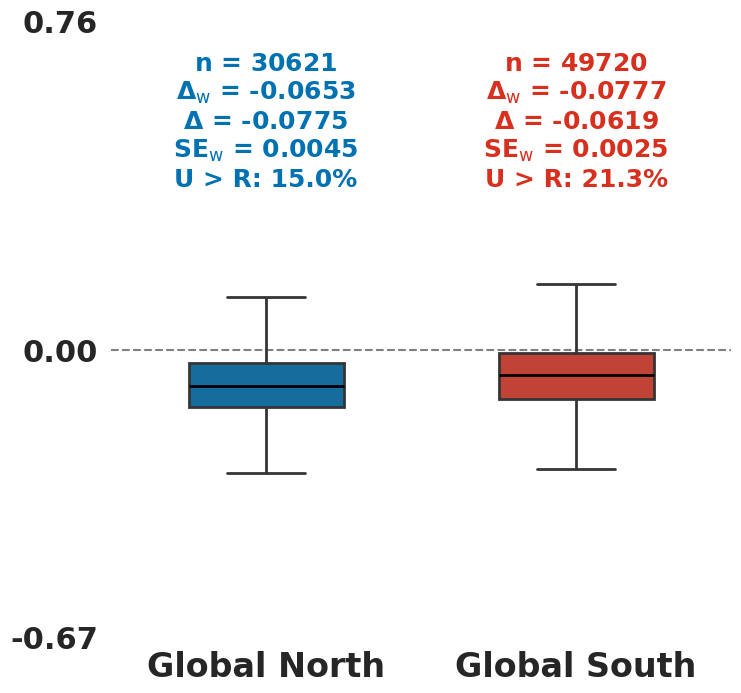

In [25]:
#!/usr/bin/env python3


from __future__ import annotations
import os
import sys
import math
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp


# ----------------------------- CONFIG --------------------------------
INPUT_CSV  = Path('/content/combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries_global_ns.csv')
OUTPUT_FIG = Path('/content/drive/MyDrive/UrbanVegetation/FiguresV3/NDVI_GNGS.pdf')

GROUP_COL  = 'GlobalNS'
PLOT_ORDER = ['Global North', 'Global South']  # fixed left→right order

# Okabe–Ito blue, Vermilion
PALETTE = {'Global North': '#0072B2', 'Global South': '#d7301f'}


# ----------------------------- HELPERS --------------------------------
def _ext_from_path(p: Path) -> str:
    ext = p.suffix.lower().lstrip('.')
    return ext if ext in {'pdf', 'png', 'svg'} else 'pdf'


def _safe_y_limits(values: pd.Series) -> Tuple[float, float]:
    """Ensure 0 is within range; add small padding; avoid zero-span."""
    v = pd.to_numeric(values, errors='coerce').dropna().astype(float)
    if v.empty:
        return (-0.1, 0.1)
    vmin, vmax = float(np.min(v)), float(np.max(v))
    vmin = min(vmin, 0.0)
    vmax = max(vmax, 0.0)
    if np.isclose(vmin, vmax):
        pad = max(abs(vmax), 0.01) * 0.1
        vmin, vmax = vmax - pad, vmax + pad
    span = vmax - vmin
    return (vmin - 0.02 * span, vmax + 0.02 * span)


def _kish_weighted_mean_se(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float, int]:
    """
    Kish-weighted mean and SE:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x − μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ w^2
      SE_w  = sqrt(Var_w / max(n_eff, 1))
    Returns (mean_w, se_w, n_eff, n_raw)
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0)
    W = float(np.sum(w))
    mu_w = float(np.sum(w * x) / W)
    var_w = float(np.sum(w * (x - mu_w) ** 2) / W)
    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return (mu_w, se_w, n_eff, n_raw)


def _stderr(series: pd.Series) -> float:
    """Unweighted sample standard error with ddof=1 (unused in annotations now)."""
    s = pd.to_numeric(series, errors="coerce").dropna()
    n = s.size
    if n < 2:
        return float("nan")
    return float(s.std(ddof=1) / math.sqrt(n))


# ----------------------------- PLOTTING --------------------------------
def _boxplot_with_annotations(df: pd.DataFrame,
                              feature: str,
                              stats_w: Dict[str, Dict[str, float]],
                              outfile: Path) -> None:
    if df.empty:
        raise ValueError("Nothing to plot – dataframe is empty.")

    plt.rcParams.update({'font.size': 24})
    sns.set(style="white")
    fig = plt.figure(figsize=(8, 8), facecolor="none")
    ax = plt.gca()
    ax.set_facecolor("none")

    # Unweighted boxplot for distributional shape
    sns.boxplot(
        x=GROUP_COL, y=feature, data=df,
        order=PLOT_ORDER, palette=PALETTE, width=0.5, showfliers=False,
        boxprops={'alpha': 1, 'linewidth': 2},
        whiskerprops={'linewidth': 2},
        capprops={'linewidth': 2},
        medianprops={'linewidth': 2, 'color': 'black'}
    )

    # y=0 reference
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, zorder=0)

    # y-lims and ticks
    ymin, ymax = _safe_y_limits(df[feature])
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([ax.get_ylim()[0], 0, ax.get_ylim()[1]])
    ax.set_yticklabels([f"{ax.get_ylim()[0]:.2f}", "0.00", f"{ax.get_ylim()[1]:.2f}"])

    # Minimal axes
    sns.despine(left=True, bottom=True, trim=True, offset=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.yticks(fontsize=22, fontweight='bold')
    plt.xticks(fontsize=24, fontweight='bold')

    # Annotations (μ_w, μ, SE_w, n, U>R %), bold mathtext + subscript w
    y0, y1 = ax.get_ylim()
    for i, label in enumerate(PLOT_ORDER):
        st = stats_w.get(label)
        if not st:
            continue
        y_pos = y1 - 0.05 * (y1 - y0)  # 5% below the top
        ann = (
            rf"$\mathbf{{n}}$ = {st['n_raw']}" + "\n" +
            rf"$\boldsymbol{{\Delta}}_{{\mathrm{{w}}}}$ = {st['mu_w']:.4f}" + "\n" +
            rf"$\boldsymbol{{\Delta}}$ = {st['mu_simple']:.4f}" + "\n" +
            rf"$\mathbf{{SE}}_{{\mathrm{{w}}}}$ = {st['se_w']:.4f}" + "\n" +
            f"U > R: {st['pct_pos']:.1f}%"
        )
        ax.text(
            i, y_pos, ann,
            ha='center', va='top', fontsize=18, fontweight='bold',
            color=PALETTE.get(label, 'black')
        )

    # Save
    outfile.parent.mkdir(parents=True, exist_ok=True)
    fmt = _ext_from_path(outfile)
    plt.savefig(outfile, dpi=400, bbox_inches='tight', format=fmt, transparent=True)
    print(f"Figure saved → {outfile}")
    plt.show()


# ----------------------------- CORE ANALYSIS ---------------------------
def analyse_all_cities_ndvi(csv_path: Path, outfig: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    # Try to read Buffer_area if available (preferred weights)
    candidate_cols = [
        'meanNDVI_2020_urban', 'meanNDVI_2020_rural', 'GlobalNS', 'Urban_Area', 'Buffer_area'
    ]
    try:
        df = pd.read_csv(csv_path, usecols=lambda c: c in candidate_cols)
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV: {e}")

    # Required basics
    req_min = ['meanNDVI_2020_urban', 'meanNDVI_2020_rural', 'GlobalNS', 'Urban_Area']
    missing_min = [c for c in req_min if c not in df.columns]
    if missing_min:
        raise ValueError(f"Required column(s) missing: {missing_min}")

    # Coerce numerics
    num_cols = [c for c in ['meanNDVI_2020_urban', 'meanNDVI_2020_rural', 'Urban_Area', 'Buffer_area'] if c in df.columns]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Clean
    before = len(df)
    df = df.dropna(subset=req_min).copy()
    df = df[df['Urban_Area'] > 0].copy()
    after = len(df)
    print(f"Valid rows after cleaning: {after:,} of {before:,}")
    if after == 0:
        raise ValueError("No valid data rows remain after cleaning.")

    # Compute ΔNDVI and group labels
    df['NDVI_diff'] = df['meanNDVI_2020_urban'] - df['meanNDVI_2020_rural']
    df[GROUP_COL] = df['GlobalNS'].replace({'North': 'Global North', 'South': 'Global South'})
    df = df[df[GROUP_COL].isin(PLOT_ORDER)].copy()
    df[GROUP_COL] = pd.Categorical(df[GROUP_COL], categories=PLOT_ORDER, ordered=True)

    # Weights for per-city difference
    if 'Buffer_area' in df.columns and df['Buffer_area'].notna().any():
        # Keep only rows with valid Buffer_area > 0 when present
        df = df.dropna(subset=['Buffer_area']).copy()
        df = df[df['Buffer_area'] > 0].copy()
        if df.empty:
            raise ValueError("No valid rows after requiring positive Buffer_area.")
        df['w_diff'] = df['Urban_Area'] + df['Buffer_area']
        weight_note = "Weights: Urban_Area + Buffer_area"
    else:
        df['w_diff'] = df['Urban_Area']
        weight_note = "Weights: Urban_Area only (Buffer_area missing)"
        print(f"[WARN] Buffer_area not found; using Urban_Area as weights.")

    # Stats per group
    stats_w: Dict[str, Dict[str, float]] = {}
    for g in PLOT_ORDER:
        gdf = df[df[GROUP_COL] == g]
        x = gdf['NDVI_diff'].to_numpy()
        w = gdf['w_diff'].to_numpy()

        mu_w, se_w, n_eff, n_raw = _kish_weighted_mean_se(x, w)
        mu_simple = float(np.nanmean(x)) if x.size else float('nan')
        n_pos = int(np.sum(x > 0))
        pct_pos = 100.0 * n_pos / n_raw if n_raw > 0 else np.nan

        stats_w[g] = {
            'n_raw': n_raw,
            'n_eff': n_eff,
            'mu_w': mu_w,     # kept for console print
            'mu_simple': mu_simple,
            'se_w': se_w,
            'pct_pos': pct_pos
        }

        # Console diagnostics
        print(f"\n[{g}] Area-weighted stats for ΔNDVI ({weight_note}):")
        print(f"  n_raw                : {n_raw}")
        print(f"  n_eff (Kish)         : {n_eff:.1f}")
        print(f"  μ_w (weighted mean)  : {mu_w:.4f}")
        print(f"  SE_w (weighted)      : {se_w:.4f}")
        print(f"  U > R                : {n_pos} / {n_raw} ({pct_pos:.1f}%)")

    # Hypothesis tests on unweighted distributions (as before)
    north = df.loc[df[GROUP_COL] == 'Global North', 'NDVI_diff']
    south = df.loc[df[GROUP_COL] == 'Global South', 'NDVI_diff']

    try:
        mw_u, mw_p = mannwhitneyu(north, south, alternative='two-sided')
    except ValueError as e:
        mw_u, mw_p = float('nan'), float('nan')
        print(f"[WARN] Mann–Whitney failed: {e}")

    try:
        ks_s, ks_p = ks_2samp(north, south)
    except ValueError as e:
        ks_s, ks_p = float('nan'), float('nan')
        print(f"[WARN] KS test failed: {e}")

    pooled_sd = math.sqrt((north.var(ddof=1) + south.var(ddof=1)) / 2.0) if (north.size > 1 and south.size > 1) else float('nan')
    cohens_d = ((north.mean() - south.mean()) / pooled_sd) if (pooled_sd and not np.isnan(pooled_sd)) else float('nan')

    print("\n─ Tests on unweighted ΔNDVI distributions ─")
    print(f"Mann–Whitney U p-value : {mw_p:.4e}" if np.isfinite(mw_p) else "Mann–Whitney U p-value : n/a")
    print(f"Kolmogorov–Smirnov p   : {ks_p:.4e}" if np.isfinite(ks_p) else "Kolmogorov–Smirnov p   : n/a")
    print(f"Cohen’s d (effect size): {cohens_d:.3f}" if np.isfinite(cohens_d) else "Cohen’s d (effect size): n/a")

    # Plot
    _boxplot_with_annotations(df[[GROUP_COL, 'NDVI_diff']], 'NDVI_diff', stats_w, outfig)
    return df


# ----------------------------- CLI ------------------------------------
def main() -> None:
    try:
        analyse_all_cities_ndvi(INPUT_CSV, OUTPUT_FIG)
    except (FileNotFoundError, ValueError, RuntimeError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected: {e}", file=sys.stderr)
        sys.exit(2)


if __name__ == "__main__":
    main()


# Climate Zones

/tmp/ipython-input-3998516031.py:75: DtypeWarning: Columns (37,39,40,42,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(INPUT_CSV)
/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in self.plot_data.groupby(grouping_vars):
/tmp/ipython-input-3998516031.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


Saved RainCloud plot → /content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig_NDVI_climate.pdf


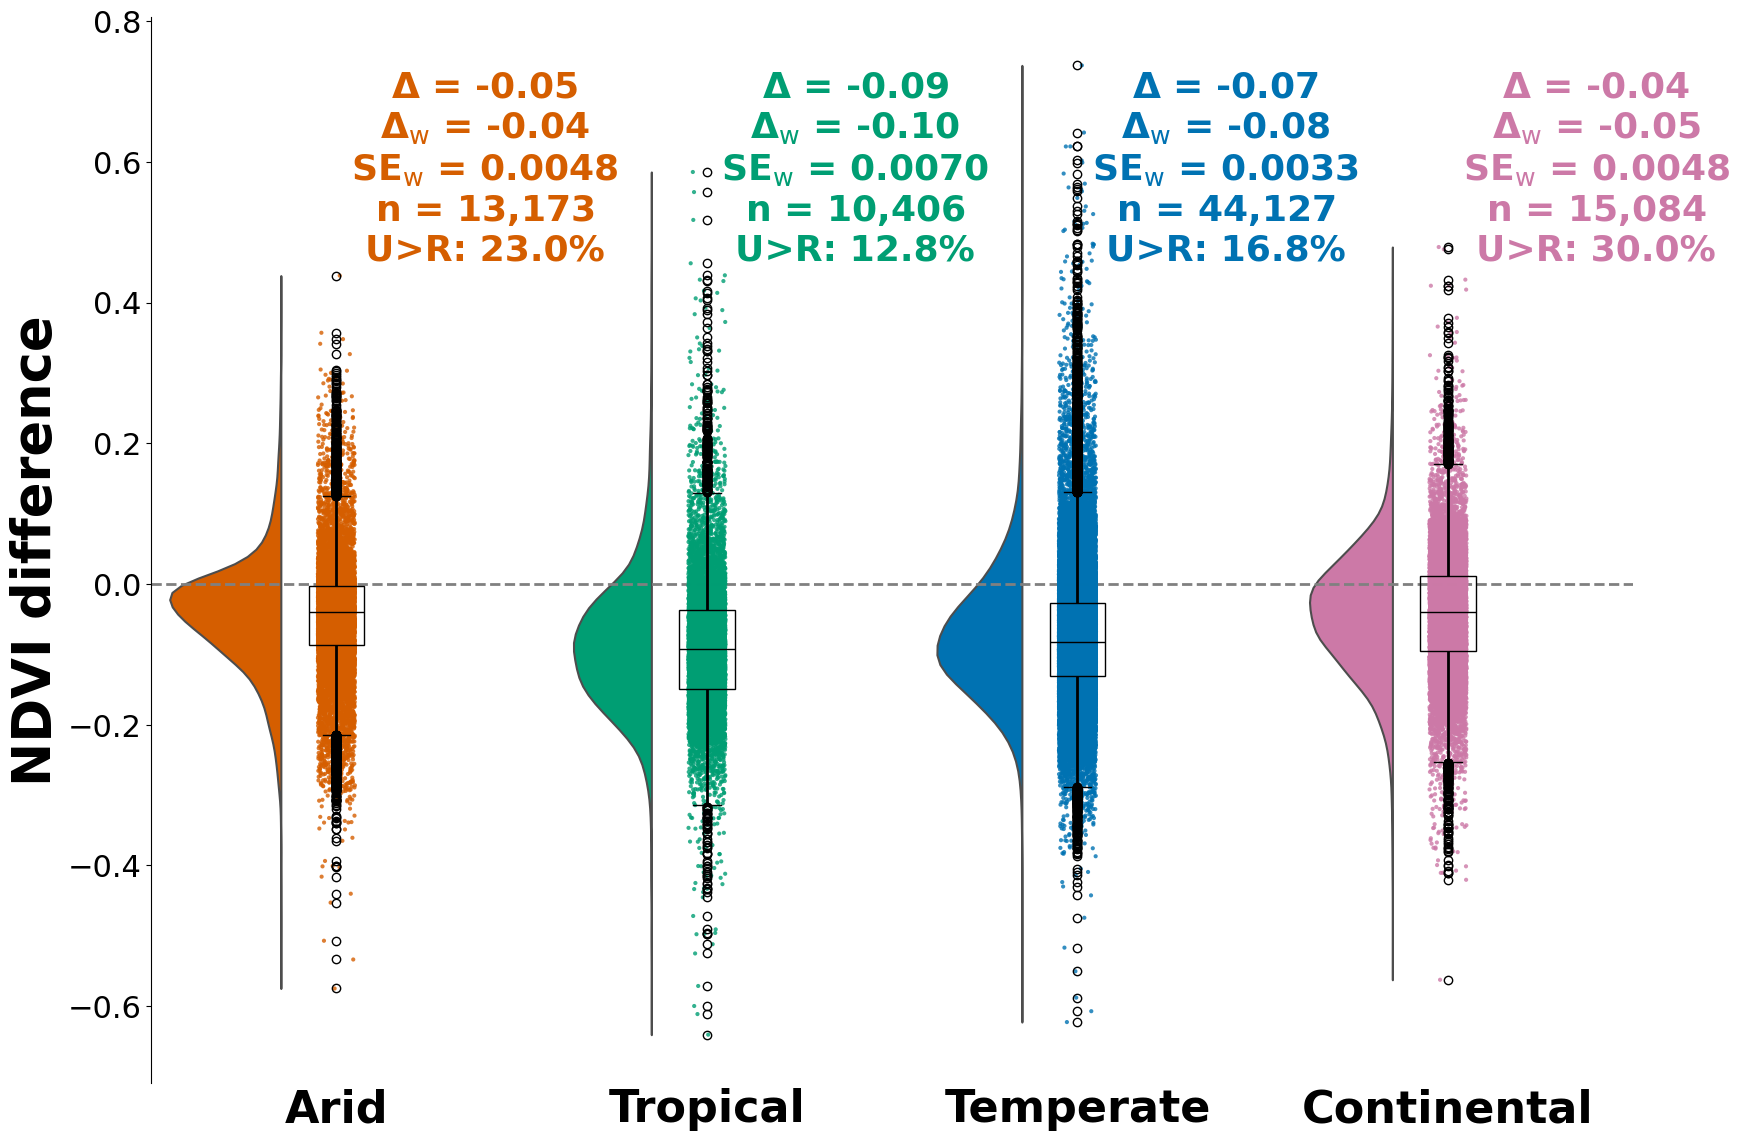

In [24]:
#!/usr/bin/env python3

import sys
import warnings
from pathlib import Path
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# ────────────────────────────────────────────────────────────────────
# SILENCE KNOWN FUTUREWARNINGS (optional)
# ────────────────────────────────────────────────────────────────────
warnings.filterwarnings(
    "ignore",
    message="The default of observed=False is deprecated",
    category=FutureWarning,
    module="seaborn"
)

# ────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────────────────────────
INPUT_CSV  = Path('/content/combinedFeatures_NDVIBiomeKoppen_withLatLon_with_countries.csv')
OUTPUT_pdf = Path('/content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig_NDVI_climate.pdf')

# Fixed class ordering and palette (CVD-safe, consistent with LAI figure)
KOPPEN_MAP   = {'A': 'Tropical', 'B': 'Arid', 'C': 'Temperate', 'D': 'Continental'}
CLASS_ORDER  = ['Arid', 'Tropical', 'Temperate', 'Continental']
PALETTE_LIST = ["#D55E00", "#009E73", "#0072B2", "#CC79A7"]  # Arid, Tropical, Temperate, Continental

# ────────────────────────────────────────────────────────────────────
# HELPERS
# ────────────────────────────────────────────────────────────────────
def _stderr(series: pd.Series) -> float:
    """Sample standard error (ddof=1). NaN if n < 2 or no finite values."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    n = s.size
    if n < 2:
        return float('nan')
    return float(s.std(ddof=1) / np.sqrt(n))

def _weighted_mean_se_with_kish(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    """
    Weighted mean and SE with Kish effective n.
    Returns (mu_w, se_w, n_eff). If invalid, returns (nan, nan, 0.0).
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    if not np.any(m):
        return np.nan, np.nan, 0.0

    x = x[m]
    w = w[m]
    W = float(w.sum())
    if W <= 0:
        return np.nan, np.nan, 0.0

    mu_w = float(np.sum(w * x) / W)
    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float(np.sum(w * (x - mu_w) ** 2) / W)
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return mu_w, se_w, n_eff

# ────────────────────────────────────────────────────────────────────
# LOAD DATA
# ────────────────────────────────────────────────────────────────────
try:
    data = pd.read_csv(INPUT_CSV)
except Exception as e:
    raise IOError(f"Error reading CSV file '{INPUT_CSV}': {e}")

# ────────────────────────────────────────────────────────────────────
# VALIDATION & PREPROCESSING
# ────────────────────────────────────────────────────────────────────
required_columns = ['meanNDVI_2020_urban', 'meanNDVI_2020_rural', 'koppen_name']
missing = [c for c in required_columns if c not in data.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

# Coerce numeric columns and drop rows with missing inputs
for col in ['meanNDVI_2020_urban', 'meanNDVI_2020_rural']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(subset=required_columns, inplace=True)

# Compute NDVI urban–rural difference
data['NDVI_diff'] = data['meanNDVI_2020_urban'] - data['meanNDVI_2020_rural']

# Map to first-letter Köppen class (drop Polar 'E' and anything unmapped)
first_letter = data['koppen_name'].astype(str).str[0]
data['koppen_class'] = first_letter.map(KOPPEN_MAP)

# Keep only mapped classes and explicit copy
data = data.dropna(subset=['koppen_class', 'NDVI_diff']).copy()

# Enforce fixed category order used in other figures
data['koppen_class'] = pd.Categorical(data['koppen_class'],
                                      categories=CLASS_ORDER,
                                      ordered=True)
data = data.dropna(subset=['koppen_class'])

# If any class is entirely absent, prune palette/order accordingly
present_classes = [c for c in CLASS_ORDER if (data['koppen_class'] == c).any()]
palette = [PALETTE_LIST[CLASS_ORDER.index(c)] for c in present_classes]
data = data[data['koppen_class'].isin(present_classes)]

if data.empty:
    raise ValueError("No data left after class mapping/filtering.")

# Determine whether area weights are available
has_weights = all(col in data.columns for col in ['Urban_Area', 'Buffer_area'])
if has_weights:
    # Guard denominators and form weights for the *difference*
    data['Urban_Area'] = pd.to_numeric(data['Urban_Area'], errors='coerce').replace(0, np.nan)
    data['Buffer_area'] = pd.to_numeric(data['Buffer_area'], errors='coerce').replace(0, np.nan)
    data['w_diff'] = data['Urban_Area'] + data['Buffer_area']
    # If after guards nothing usable, treat as unweighted
    if not np.isfinite(data['w_diff']).any() or (data['w_diff'].fillna(0) <= 0).all():
        has_weights = False

# ────────────────────────────────────────────────────────────────────
# CLASS-WISE STATS (weighted if possible; else unweighted)
# ────────────────────────────────────────────────────────────────────
stats = {}
for klass in present_classes:
    grp = data.loc[data['koppen_class'] == klass, 'NDVI_diff']
    grp = pd.to_numeric(grp, errors='coerce').dropna()
    n_raw = int(grp.size)
    mu_simple = float(grp.mean()) if n_raw > 0 else float('nan')
    se_simple = _stderr(grp)
    upr_pct = float((grp > 0).mean() * 100.0) if n_raw > 0 else float('nan')

    mu_w = se_w = n_eff = np.nan
    if has_weights:
        w = data.loc[data['koppen_class'] == klass, 'w_diff']
        x = data.loc[data['koppen_class'] == klass, 'NDVI_diff']
        x = pd.to_numeric(x, errors='coerce').to_numpy()
        w = pd.to_numeric(w, errors='coerce').to_numpy()
        mu_w, se_w, n_eff = _weighted_mean_se_with_kish(x, w)

    stats[klass] = {
        'n_raw': n_raw,
        'mu_simple': mu_simple,
        'se_simple': se_simple,
        'mu_w': mu_w,
        'se_w': se_w,
        'n_eff': n_eff,
        'upr_pct': upr_pct
    }

# ────────────────────────────────────────────────────────────────────
# PLOTTING (LAI RainCloud style)
# ────────────────────────────────────────────────────────────────────
plt.rcParams.update({"font.size": 26})
fig, ax = plt.subplots(figsize=(18, 12), facecolor='none')  # transparent bg

# RainCloud: half-violin (distribution unweighted)
pt.half_violinplot(
    x='koppen_class', y='NDVI_diff', data=data,
    palette=palette, bw=.2, cut=0, scale="area",
    width=.6, inner=None, orient='v', order=present_classes, ax=ax
)

# Boxplot overlay (thin, transparent fill)
sns.boxplot(
    x='koppen_class', y='NDVI_diff', data=data,
    width=.15, showcaps=True, boxprops={'facecolor': 'none'},
    whiskerprops={'linewidth': 2}, capprops={'zorder': 10},
    whis=1.5, color='black', zorder=10, order=present_classes, ax=ax
)

# Stripplot overlay
sns.stripplot(
    x='koppen_class', y='NDVI_diff', data=data,
    palette=palette, jitter=0.05, size=3, alpha=0.8,
    orient='v', order=present_classes, ax=ax
)

# Zero line & minimalist styling
ax.axhline(0, color='gray', linestyle='--', linewidth=2)
ax.grid(False)
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='x', length=0)

# Labels
ax.set_ylabel('NDVI difference', fontsize=38, fontweight='bold')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), fontsize=32, fontweight='bold')
plt.yticks(fontsize=22)

# Statistical annotations (match example's look)
ymin, ymax = ax.get_ylim()
y_text = ymax - 0.05 * (ymax - ymin)

for i, klass in enumerate(present_classes):
    s = stats[klass]
    n_raw     = s['n_raw']
    mu_simple = s['mu_simple']
    se_simple = s['se_simple']
    upr       = s['upr_pct']

    if has_weights and np.isfinite(s['mu_w']):
        mu_w  = s['mu_w']
        se_w  = s['se_w']
        # Bold μ (simple), μ_w, SE_w, n, plus U>R. Matches example layout/order.
        ann = (
            rf"$\boldsymbol{{\Delta}}$ = {mu_simple:.2f}" + "\n" +
            rf"$\boldsymbol{{\Delta}}_{{\mathrm{{w}}}}$ = {mu_w:.2f}" + "\n" +
            rf"$\mathbf{{SE}}_{{\mathrm{{w}}}}$ = {se_w:.4f}" + "\n" +
            rf"$\mathbf{{n}}$ = {n_raw:,}" + "\n" +
            f"U>R: {upr:.1f}%"
        )
    else:
        # No weights: show bold μ, bold SE (unweighted), bold n, U>R.
        ann = (
            rf"$\boldsymbol{{\Delta}}$ = {mu_simple:.2f}" + "\n" +
            rf"$\mathbf{{SE}}$ = {se_simple:.4f}" + "\n" +
            rf"$\mathbf{{n}}$ = {n_raw:,}" + "\n" +
            f"U>R: {upr:.1f}%"
        )

    ax.text(
        i + 0.40, y_text, ann,
        ha='center', va='top',
        fontsize=26, fontweight='bold',
        color=palette[i]
    )

plt.tight_layout()

# ────────────────────────────────────────────────────────────────────
# SAVE
# ────────────────────────────────────────────────────────────────────
OUTPUT_pdf.parent.mkdir(parents=True, exist_ok=True)
try:
    fig.savefig(OUTPUT_pdf, dpi=400, bbox_inches='tight', transparent=True)
    print(f"Saved RainCloud plot → {OUTPUT_pdf}")
except Exception as e:
    raise IOError(f"Error saving figure to '{OUTPUT_pdf}': {e}")
finally:
    plt.show()
